# Notebook Overview
The objective of this notebook is to clean and explore historical avalanche danger ratings for the Sea to Sky region as reported by Avalanche Canada (https://www.avalanche.ca/). Specifically, this notebook creates a final cleaned dataset and attempts to assess anomalies between day of danger ratings and one- and two-day out forecasted danger ratings. 

#### The Data
The dataset covers the period 2011-11-02 through 2020-04-15 and includes day of danger ratings and one- and two-day out forecasted danger ratings. Additionally, any snowpack problems, as written by the forecaster, are included for day of danger ratings. The dataset was scraped from the Avalanche Canada forecast archives (https://www.avalanche.ca/forecasts/archives) using Selenium and Python. 

#### Key Terms
A few key terms that are important to understand in this analysis:
* Day of Conditions - The current days avalanche danger ratings. This is the most up to date condition forecast.
* Day of Conditions Plus 1 and 2 - Tomorrow and the day after tomorrows forecasted danger ratings. These are always superceded by the Day of Conditions.
* Avalanche Status Code - Avalanche danger ratings on a scale of 1-5 with 5 being Extreme and 1 being Low
* Alpine - Elevations above treeline
* Treeline - Elevations at or near treeline
* Below Treeline - Elevations in the trees
* Forecast Anamoly - Difference between forecasted value and observed/reported value.

#### Notebook Outline
A basic outline for the notebook is as follows:
1. Load data
2. Clean data
3. Explore Data - visualize danger rating data
4. Data Analysis - assess forecasted danger rating anomalies

## Library Imports

In [19]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import Counter

## Helper Functions

In [20]:
# helper functions
def percent_missing(df, name):
    '''function to compute the percent NaN data in each column of a dataframe'''
    
    perc_missing = df.isna().sum() / len(df) * 100
    
    return print('Percent Missing in Each Column Before Filtering:', name, '\n \n', perc_missing, '\n')

def zero_matrix():
    '''function to create a zero matrix for seaborn heatmap plotting'''
    
    df = pd.DataFrame(np.zeros((5,5)), index=[5,4,3,2,1])  # reverse for plotting purposes
    df.columns = [1,2,3,4,5]
    
    return df

## Load Dataset

In [21]:
# define absolute path to raw data folder
raw_data_root_path = os.path.abspath('../data/raw')

# raw data filenames
current_conditions_file = 'current_avalanche_conditions_sea_to_sky.csv'  # day of forecast
current_plus1_conditions_file = 'current_plus1_avalanche_conditions_sea_to_sky.csv'  # tomorrow forecast
current_plus2_conditions_file = 'current_plus2_avalanche_conditions_sea_to_sky.csv'  # day after tomorrow forecast
  
# define absolute path to raw data files
current_conditions_path = os.path.join(raw_data_root_path, current_conditions_file)
current_plus1_conditions_path = os.path.join(raw_data_root_path, current_plus1_conditions_file)
current_plus2_conditions_path = os.path.join(raw_data_root_path, current_plus2_conditions_file) 

# load raw data to dataframe, parse dates as datetime index
df_raw_current = pd.read_csv(current_conditions_path, parse_dates=['date_valid'])
df_raw_current_plus1 = pd.read_csv(current_plus1_conditions_path, parse_dates=['date_valid'])
df_raw_current_plus2 = pd.read_csv(current_plus2_conditions_path, parse_dates=['date_valid'])

## Clean Dataset

In [22]:
# list of dataframes to clean
dataframes = [df_raw_current, df_raw_current_plus1, df_raw_current_plus2]

# check for percent missing values for each dataframe
for df, name in zip(dataframes, ['current', 'current+1', 'current+2']):
    percent_missing(df, name)
    
# # replace zero values with NaN and remove any row that has NaN value for avalanche status
for df in dataframes:
    df.replace(0.0, np.nan, inplace=True)
    df.dropna(subset=['alpine_status_code', 'treeline_status_code', 'belowtree_status_code'], inplace=True)
    
# remove extra row in current day forecast
df_raw_current.drop(columns=['Unnamed: 8'], inplace=True)

# replace missing problem text with No Text statement
df_raw_current['problems'].replace(np.nan, 'No Text', inplace=True)

# assign dataframes to new processed dataframe
df_cleaned_current = df_raw_current
df_cleaned_current_plus1 = df_raw_current_plus1
df_cleaned_current_plus2 = df_raw_current_plus2

# save cleaned dataset
df_cleaned_current.to_csv('../data/cleaned/current_avalanche_danger_ratings_sea_to_sky_2011_2012.csv')
df_cleaned_current_plus1.to_csv('../data/cleaned/current_plus1_avalanche_danger_ratings_sea_to_sky_2011_2012.csv')
df_cleaned_current_plus2.to_csv('../data/cleaned/current_plus2_avalanche_danger_ratings_sea_to_sky_2011_2012.csv')

Percent Missing in Each Column Before Filtering: current 
 
 date_valid                0.000000
alpine_status             7.440101
alpine_status_code        7.440101
treeline_status           7.440101
treeline_status_code      7.440101
belowtree_status          7.440101
belowtree_status_code     7.440101
problems                 26.607818
Unnamed: 8               99.810845
dtype: float64 

Percent Missing in Each Column Before Filtering: current+1 
 
 date_valid               0.000000
alpine_status            7.440101
alpine_status_code       7.440101
treeline_status          7.440101
treeline_status_code     7.440101
belowtree_status         7.440101
belowtree_status_code    7.440101
dtype: float64 

Percent Missing in Each Column Before Filtering: current+2 
 
 date_valid               0.000000
alpine_status            7.440101
alpine_status_code       7.440101
treeline_status          7.440101
treeline_status_code     7.440101
belowtree_status         7.440101
belowtree_status_code 

## Explore Data

#### Custom Colormap

In [67]:
colors = [(82/255, 186/255, 74/255), (255/255, 243/255, 0/255), (247/255, 146/255, 24/255), 
          (239/255, 28/255, 41/255), (0/255, 0/255, 0/255)]

#### Visualization of "Day of Conditions" in Sea to Sky Region 2011-2020

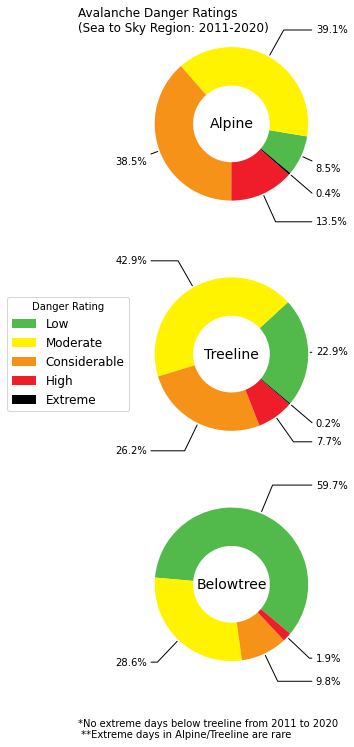

In [140]:
# percent occurence of each avalanche condition for each elevation
avy_perc_occur_alpine = df_cleaned_current['alpine_status_code'].value_counts(normalize=True) * 100
avy_perc_occur_treeline = df_cleaned_current['treeline_status_code'].value_counts(normalize=True) * 100
avy_perc_occur_belowtree = df_cleaned_current['belowtree_status_code'].value_counts(normalize=True) * 100

# combine into one dataframe for plotting ease
avy_perc_occur_all_elev = pd.concat([avy_perc_occur_alpine, avy_perc_occur_treeline, avy_perc_occur_belowtree], axis=1)

# properties for donut charts
status_labels = ['Low', 'Moderate', 'Considerable', 'High', 'Extreme']
title_labels = ['Alpine', 'Treeline', 'Belowtree']

# create donut chart for each elevation
fig, ax = plt.subplots(3,1,figsize=(7,12), subplot_kw=dict(aspect="equal"), facecolor='white')

for i, col in enumerate(avy_perc_occur_all_elev):
    
    data = avy_perc_occur_all_elev[col]  # column of dataframe to render
    data.dropna(inplace=True)  # remove any NaN rows
        
    donut_labels = [str(round(y,1)) + '%' for y in list(data)]
            
    wedges, texts = ax[i].pie(data, wedgeprops=dict(width=0.5), startangle=-40, colors = colors)  # create donut chart
        
    #  create lines and labels
    kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    
    for j, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1  # a bit of 9th grade geometry
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax[i].annotate(donut_labels[j], xy=(x, y), xytext=(1.1*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
        
    ax[i].text(0,0,title_labels[i], fontsize='14', ha='center', va='center')  # add title to donut center
    
    # overall title
    if i == 0:
        ax[i].text(-2,1.2,'Avalanche Danger Ratings \n(Sea to Sky Region: 2011-2020)', fontsize='12')
    
    # legend
    if i == 1:
        ax[i].legend(wedges, status_labels, title="Danger Rating", loc='center left', 
                     bbox_to_anchor=(-0.7, 0.25, 0.5, 0.5), prop=dict(size=12))
# notes about dataset       
ax[2].text(-2, -2, '*No extreme days below treeline from 2011 to 2020 \n **Extreme days in Alpine/Treeline are rare')

plt.savefig('../figures/avalanche-danger-ratings-sea-to-sky-2011-2020.png')

#### Visualization of "Day of Conditions" by year

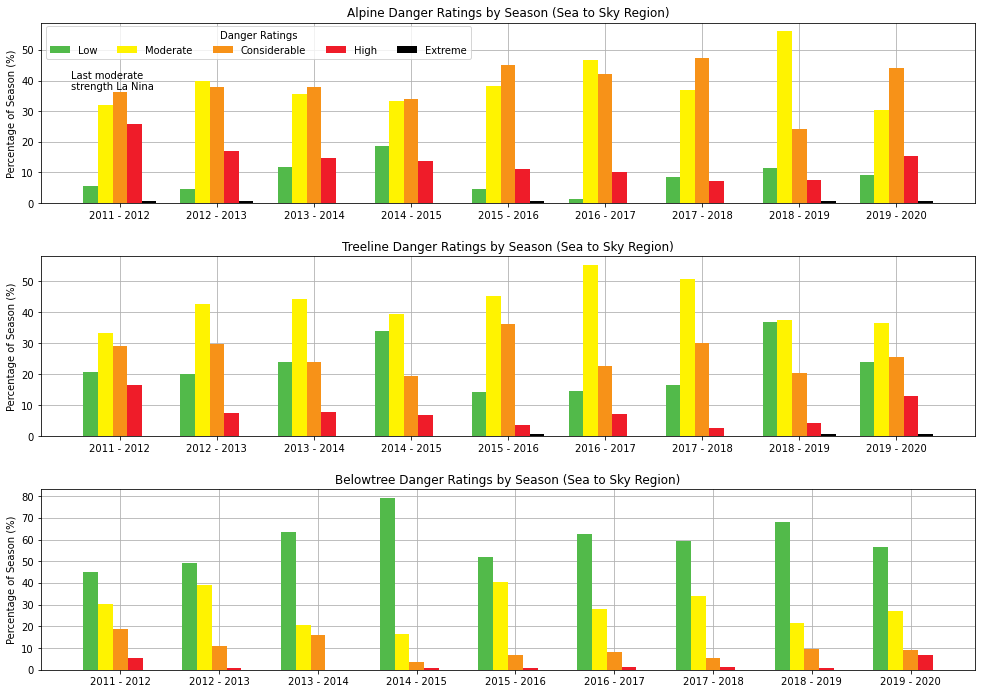

In [145]:
# list of years in dataset
years = df_cleaned_current.date_valid.dt.year.unique()

# initialize empty list
alpine_conditions = []
treeline_conditions = []
belowtree_conditions = []
year_labels = []

for i, year in enumerate(years[:-1]):
    
    # define avalanche season
    start = '{}-11-01'.format(year)
    end = '{}-05-01'.format(year+1)
        
    # create label for figure
    label = '{} - {}'.format(year, year+1)
    year_labels.append(label)
        
    # creates list of avalanche conditions for each season at each elevation
    alpine_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['alpine_status_code'].value_counts(normalize=True) * 100)
   
    treeline_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['treeline_status_code'].value_counts(normalize=True) * 100)
    
    belowtree_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['belowtree_status_code'].value_counts(normalize=True) * 100)
    
# creates dataframes from lists
df_alpine = pd.DataFrame(alpine_conditions)
df_treeline = pd.DataFrame(treeline_conditions)
df_belowtree = pd.DataFrame(belowtree_conditions)
                                     
fig, ax = plt.subplots(3,1,figsize=(14,10), facecolor="white")

# define plot properties
title_label = ['Alpine', 'Treeline', 'Belowtree']
x = np.arange(len(alpine_conditions))
width = 0.15

# create bar charts
for i, df in enumerate([df_alpine, df_treeline, df_belowtree]):
    
    rects1 = ax[i].bar(x - width*2, df[1], width, label='Low', zorder=3, color=colors[0])
    rects2 = ax[i].bar(x - width, df[2], width, label='Moderate', zorder=3, color=colors[1])
    rects3 = ax[i].bar(x, df[3], width, label='Considerable', zorder=3, color=colors[2])
    rects4 = ax[i].bar(x + width, df[4], width, label='High', zorder=3, color=colors[3])
    
    if 5 in df.columns:
        rects5 = ax[i].bar(x + width*2, df[5], width, label='Extreme', zorder=3, color=colors[4])
        
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(year_labels)
    ax[i].set_title('{} Danger Ratings by Season (Sea to Sky Region)'.format(title_label[i]))
    ax[i].set_ylabel('Percentage of Season (%)')
    ax[i].grid(zorder=0)

# add legend and text
ax[0].legend(title="Danger Ratings", loc='center left', bbox_to_anchor=(0, 0.64, 0.5, 0.5), ncol=5)
ax[0].text(-0.5,37,'Last moderate \nstrength La Nina')

fig.tight_layout(pad=2)

plt.savefig('../figures/avalanche-danger-ratings-by-season-sea-to-sky-2011-2020.png')

#### Visualization of "Day of Conditions" by month

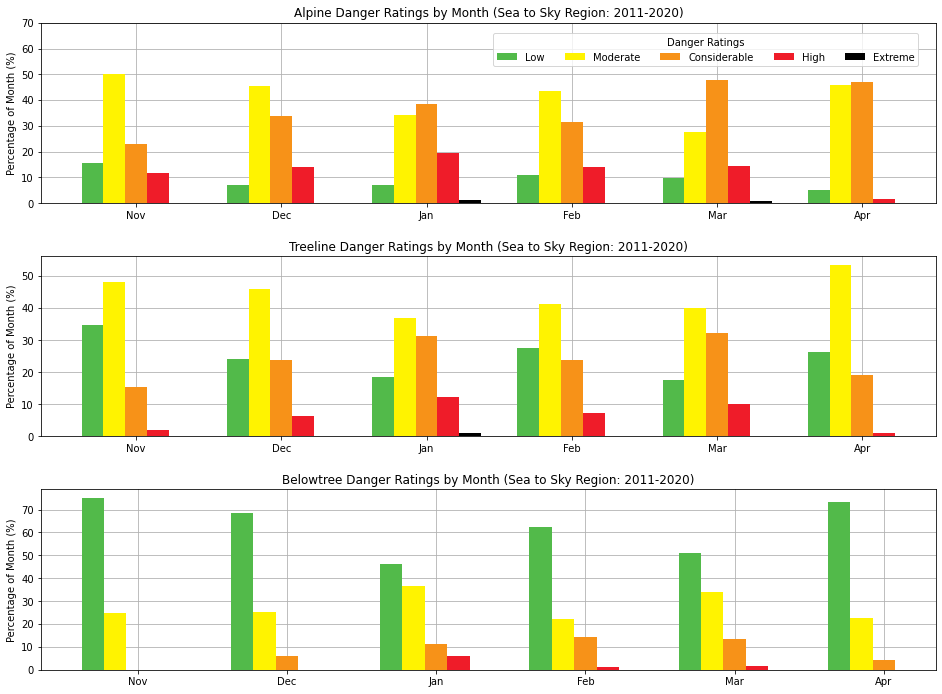

In [150]:
# list of months in dataset
months = [11, 12, 1, 2, 3, 4]

# initialize empty lists
alpine_conditions = []
treeline_conditions = []
belowtree_conditions = []
year_labels = []

for month in months:
    
    # creates list of avalanche danger ratins for each month at each elevation
    alpine_conditions.append(df_cleaned_current[df_cleaned_current.date_valid.dt.month == month]
                             ['alpine_status_code'].value_counts(normalize=True) * 100)
    
    treeline_conditions.append(df_cleaned_current[df_cleaned_current.date_valid.dt.month == month]
                             ['treeline_status_code'].value_counts(normalize=True) * 100)
        
    belowtree_conditions.append(df_cleaned_current[df_cleaned_current.date_valid.dt.month == month]
                             ['belowtree_status_code'].value_counts(normalize=True) * 100)
    
# creates dataframes from lists
df_alpine = pd.DataFrame(alpine_conditions)
df_treeline = pd.DataFrame(treeline_conditions)
df_belowtree = pd.DataFrame(belowtree_conditions)
                            
fig, ax = plt.subplots(3,1,figsize=(14,10), facecolor="white")

# define plot properties
title_label = ['Alpine', 'Treeline', 'Belowtree']
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
x = np.arange(len(months))
width = 0.15

# create bar charts
for i, df in enumerate([df_alpine, df_treeline, df_belowtree]):
    
    rects1 = ax[i].bar(x - width*2, df[1], width, label='Low', zorder=3, color=colors[0])
    rects2 = ax[i].bar(x - width, df[2], width, label='Moderate', zorder=3, color=colors[1])
    rects3 = ax[i].bar(x, df[3], width, label='Considerable', zorder=3, color=colors[2])
    rects4 = ax[i].bar(x + width, df[4], width, label='High', zorder=3, color=colors[3])
    
    # trick to avoid plotting error when extreme doesn't exist
    if 5 in df.columns:
        rects5 = ax[i].bar(x + width*2, df[5], width, label='Extreme', zorder=3, color=colors[4])
        
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(month_labels)
    ax[i].set_title('{} Danger Ratings by Month (Sea to Sky Region: 2011-2020)'.format(title_label[i]))
    ax[i].set_ylabel('Percentage of Month (%)')
    ax[i].grid(zorder=0)
    
# legend and limits
ax[0].legend(title="Danger Ratings", loc='center left', bbox_to_anchor=(0.5, 0.6, 0.5, 0.5), ncol=5)
ax[0].set_ylim([0, 70])

fig.tight_layout(pad=2)

plt.savefig('../figures/avalanche-danger-ratings-by-month-sea-to-sky-2011-2020.png')

## Data Analysis

#### Most common avalanche problems

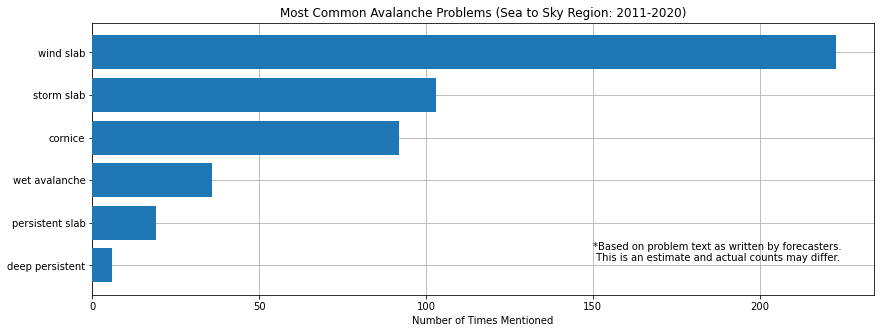

In [148]:
# types of problems to search in text based on Simon Fraser document
avy_problem_types = ['storm slab', 'wind slab', 'wet avalanche', 'cornice', 'persistent slab', 
                     'deep persistent', 'wet loose']

# initialize empty list
count = []

# loops through reported problems and matches with problem types
for problem in df_cleaned_current.problems:
    
    for avy_problem_type in avy_problem_types:
        
        if avy_problem_type in problem.lower().replace('.',''):
            count.append(avy_problem_type)
            
# creates a count of the most common problem types 
common_problem_count = pd.DataFrame(Counter(count).most_common()).sort_values(by=[1])

fig, ax = plt.subplots(1,1,figsize=(14,5), facecolor="white")

# bar plot
ax.barh(common_problem_count[0], common_problem_count[1], zorder=3)
ax.set_xlabel('Number of Times Mentioned')
ax.set_title('Most Common Avalanche Problems (Sea to Sky Region: 2011-2020)')
ax.text(150,0.1,'*Based on problem text as written by forecasters. \n This is an estimate and actual counts may differ.')
ax.grid(zorder=0)

plt.savefig('../figures/frequency-of-avalanche-problem-types-sea-to-sky-2011-2020.png')

#### Danger Rating Forecast Anomaly

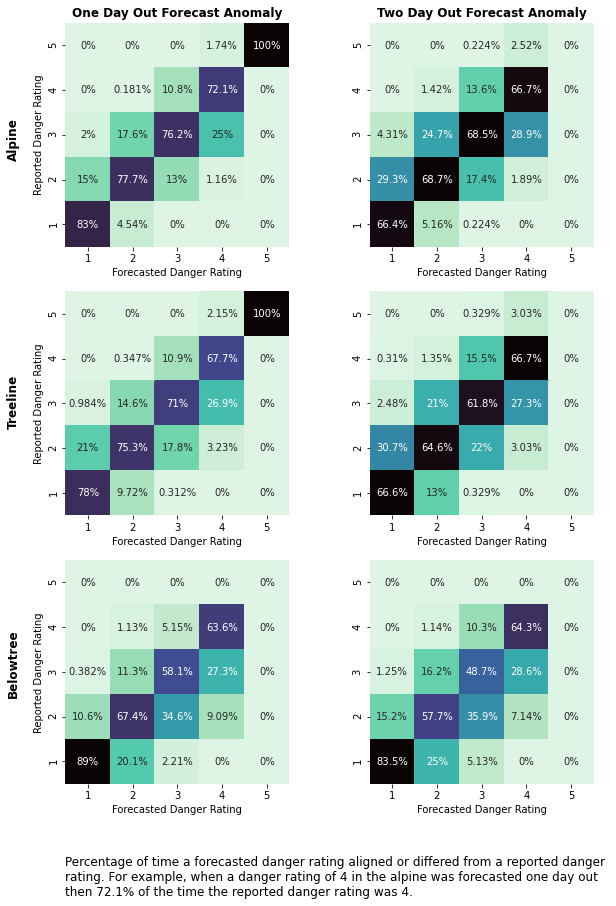

In [152]:
# merge day of and forecasted datasets
df_now_plus1 = pd.merge(df_cleaned_current, df_cleaned_current_plus1, left_on='date_valid', right_on='date_valid')
df_now_plus2 = pd.merge(df_cleaned_current, df_cleaned_current_plus2, left_on='date_valid', right_on='date_valid')

# initiate empty matrix to fill
df_alpine_now_plus1 = zero_matrix()
df_treeline_now_plus1 = zero_matrix()
df_belowtree_now_plus1 = zero_matrix()

df_alpine_now_plus2 = zero_matrix()
df_treeline_now_plus2 = zero_matrix()
df_belowtree_now_plus2 = zero_matrix()

# for each danger rating in day of conditions check frequency of forecasted danger rating across all ratings
for i in [1,2,3,4,5]:
    
    for j in [1,2,3,4,5]:
        
        alp_tmp_1 = len(df_now_plus1[(df_now_plus1.alpine_status_code_x == j) & (df_now_plus1.alpine_status_code_y == i)])
        alp_tmp_1 = (alp_tmp_1 / len(df_now_plus1[df_now_plus1.alpine_status_code_y == i])) * 100
        
        alp_tmp_2 = len(df_now_plus2[(df_now_plus2.alpine_status_code_x == j) & (df_now_plus2.alpine_status_code_y == i)])
        if i == 5:
            alp_tmp_2 = 0
        else:
            alp_tmp_2 = (alp_tmp_2 / len(df_now_plus2[df_now_plus2.alpine_status_code_y == i])) * 100
        
        treeline_tmp_1 = len(df_now_plus1[(df_now_plus1.treeline_status_code_x == j) & (df_now_plus1.treeline_status_code_y == i)])
        treeline_tmp_1 = (treeline_tmp_1 / len(df_now_plus1[df_now_plus1.treeline_status_code_y == i])) * 100
        
        treeline_tmp_2 = len(df_now_plus2[(df_now_plus2.treeline_status_code_x == j) & (df_now_plus2.treeline_status_code_y == i)])
        if i == 5:
            treeline_tmp_2 = 0
        else:
            treeline_tmp_2 = (treeline_tmp_2 / len(df_now_plus2[df_now_plus2.treeline_status_code_y == i])) * 100
        
        belowtree_tmp_1 = len(df_now_plus1[(df_now_plus1.belowtree_status_code_x == j) & (df_now_plus1.belowtree_status_code_y == i)])
        belowtree_tmp_2 = len(df_now_plus2[(df_now_plus2.belowtree_status_code_x == j) & (df_now_plus2.belowtree_status_code_y == i)])

        if i == 5:
            belowtree_tmp_1 = 0
            belowtree_tmp_2 = 0
        else:
            belowtree_tmp_1 = (belowtree_tmp_1 / len(df_now_plus1[df_now_plus1.belowtree_status_code_y == i])) * 100
            belowtree_tmp_2 = (belowtree_tmp_2 / len(df_now_plus2[df_now_plus2.belowtree_status_code_y == i])) * 100

        # store data in prealocated dataframe
        df_alpine_now_plus1[i].loc[j] = alp_tmp_1
        df_treeline_now_plus1[i].loc[j] = treeline_tmp_1
        df_belowtree_now_plus1[i].loc[j] = belowtree_tmp_1
        
        df_alpine_now_plus2[i].loc[j] = alp_tmp_2
        df_treeline_now_plus2[i].loc[j] = treeline_tmp_2
        df_belowtree_now_plus2[i].loc[j] = belowtree_tmp_2
        
# create heatmaps
df_list = [df_alpine_now_plus1, df_alpine_now_plus2, df_treeline_now_plus1, 
           df_treeline_now_plus2, df_belowtree_now_plus1, df_belowtree_now_plus2]

# labels 
labels = ['Alpine', '', 'Treeline', '', 'Belowtree', '']

fig, ax = plt.subplots(3, 2, figsize=(10,14), facecolor="white")
ax = ax.flatten()

# create heatmaps
for i, df in enumerate(df_list):

    ax[i] = sns.heatmap(df, annot=df, fmt='.3g', cmap='mako_r', cbar=False, square=True, ax=ax[i])
    
    ax[i].set_xlabel('Forecasted Danger Rating')
    for t in ax[i].texts: 
        t.set_text(t.get_text() + "%")
        
    if i % 2 == 0:
        ax[i].text(-1.3,3,labels[i], rotation=90, fontweight='bold', fontsize='12')
        ax[i].set_ylabel('Reported Danger Rating')

ax[0].set_title('One Day Out Forecast Anomaly', fontweight='bold', fontsize='12')
ax[1].set_title('Two Day Out Forecast Anomaly', fontweight='bold', fontsize='12')

ax[4].text(0, 7.5, 'Percentage of time a forecasted danger rating aligned or differed \
from a reported danger \nrating. For example, when a danger rating of 4 in the alpine was forecasted one day out \
\nthen 72.1% of the time the reported danger rating was 4.', fontsize='12')

plt.savefig('../figures/one_and_two_day_forecast_anomaly.png')